# Modelling

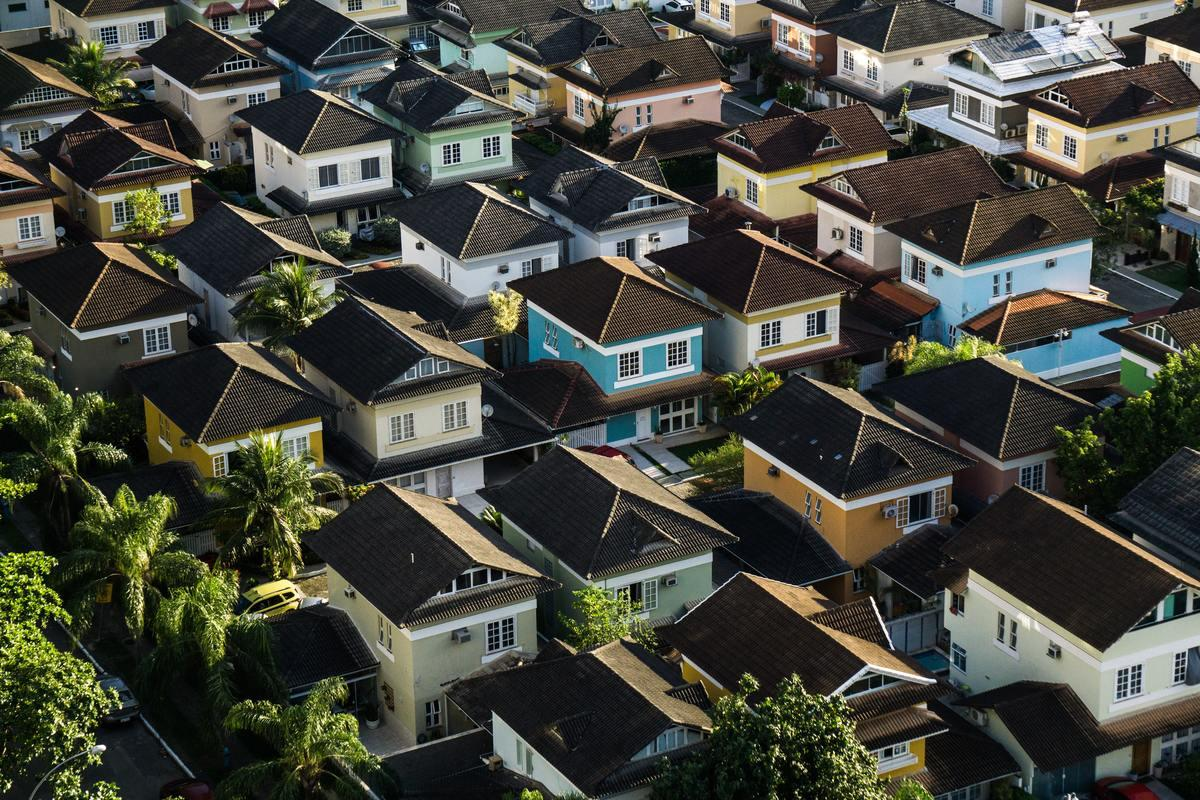

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import statsmodels.api as sm
import folium

from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import CooksDistance

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
# Open the csv from the data cleaning notebook
df = pd.read_csv('./data/final.csv', index_col=0)

merged_king_data = df.copy()

## Functions for our Analysis

In [3]:
# VIF dataframe
def cal_vif(X):
    """
    Variance inflation factor, VIF, for one exogenous variable

    The variance inflation factor is a measure for multicollinearity.

    One recommendation is that if VIF is greater than 10, then the explanatory variable is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.

    Parameters
    X{ndarray, DataFrame}

    Returns
    DataFrame
    """
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

In [4]:
def summary_model(model, X, y):
    """
    Summarize the Regression Results.

    Parameters
    model
    Fitted scikitlearn linear model.  
    
    X
    Names for the exogenous variables. Must match the number of parameters in the model.
    
    y
    Name of endogenous (response) variable.

    Returns
    Summary

    """
    
    result = (
        print(f'R-squared: {model.score(X,y)} \nIntercept: {model.intercept_} \nCoefficient: {model.coef_}')
    )
    return result

### Data Engineering and transformation

In [5]:
merged_king_data['price'] = np.log(merged_king_data['price'])

In [6]:
merged_king_data['bathrooms_per_bedroom'] = merged_king_data['bathrooms'] / merged_king_data['bedrooms']
merged_king_data.drop(columns=['bathrooms', 'bedrooms'], axis=1)

,price,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15,city,bathrooms_per_bedroom
0,2.516760,1220,8075,1.0,NONE,Fair,7,890,1969,98001,1290,7800,Auburn,0.250000
1,2.531093,2240,4648,2.0,NONE,Average,7,2240,2005,98001,2221,4557,Auburn,0.625000
2,2.568772,2714,17936,2.0,NONE,Average,9,2714,2005,98001,2590,18386,Auburn,0.833333
3,2.548965,2160,9528,2.0,NONE,Average,9,2160,1992,98001,2280,9937,Auburn,0.625000
4,2.513319,1450,11204,1.0,NONE,Average,7,1450,2003,98001,1520,9518,Auburn,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20223,2.584253,1550,1280,2.0,NONE,Average,9,1220,2013,98199,1550,1579,Seattle,1.083333
20224,2.633317,3660,4760,2.0,NONE,Average,9,2840,2014,98199,3210,4640,Seattle,0.875000
20225,2.626512,3610,4000,2.0,NONE,Average,9,2640,2007,98199,1980,4000,Seattle,0.812500
20226,2.566767,1510,1618,2.5,NONE,Average,8,1330,2011,98199,1350,1397,Seattle,0.833333


In [7]:
merged_king_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15,city,bathrooms_per_bedroom
0,2.516760,4,1.0,1220,8075,1.0,NONE,Fair,7,890,1969,98001,1290,7800,Auburn,0.250000
1,2.531093,4,2.5,2240,4648,2.0,NONE,Average,7,2240,2005,98001,2221,4557,Auburn,0.625000
2,2.568772,3,2.5,2714,17936,2.0,NONE,Average,9,2714,2005,98001,2590,18386,Auburn,0.833333
3,2.548965,4,2.5,2160,9528,2.0,NONE,Average,9,2160,1992,98001,2280,9937,Auburn,0.625000
4,2.513319,3,2.0,1450,11204,1.0,NONE,Average,7,1450,2003,98001,1520,9518,Auburn,0.666667


In [8]:
X = merged_king_data.drop(columns='price')
y = merged_king_data['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

cat_cols = [c for c in merged_king_data if merged_king_data[c].dtype == 'O']
cat_cols

X_train.describe(include=['O'])

,view,condition,city
count,15171,15171,15171
unique,5,5,22
top,NONE,Average,Seattle
freq,13647,9852,6750


In [9]:
# Import our One Hot Encoder
from sklearn.preprocessing import OneHotEncoder
# Going to use ColumnTransformer to encode only cat cols
from sklearn.compose import ColumnTransformer

In [11]:
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first', 
                        categories='auto')

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough')

ct.fit(X_train)
X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

In [12]:
X_train_enc

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.42000000e+03, 2.32740000e+04, 5.00000000e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.44000000e+03, 5.10200000e+03, 3.33333333e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.23000000e+03, 1.19000000e+04, 5.83333333e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.02000000e+03, 7.30000000e+03, 8.33333333e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.45000000e+03, 3.39450000e+04, 7.00000000e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.40500000e+03, 3.00000000e+03, 1.00000000e+00]])

In [ ]:
# X_train_enc.todense()

In [13]:
len(y_train)

15171

In [14]:
X_train_enc = pd.DataFrame(X_train_enc, columns= ct.get_feature_names(), index = X_train.index) ##emoved X_train_enc.todense()
X_train_enc


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ohe__x0_EXCELLENT,ohe__x0_FAIR,ohe__x0_GOOD,ohe__x0_NONE,ohe__x1_Fair,ohe__x1_Good,ohe__x1_Poor,ohe__x1_Very Good,ohe__x2_Bellevue,ohe__x2_Black Diamond,...,sqft_living,sqft_lot,floors,grade,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15,bathrooms_per_bedroom
5900,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3340.0,24755.0,2.0,10.0,3340.0,2002.0,98038.0,3420.0,23274.0,0.500000
20195,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1650.0,5102.0,1.0,8.0,1300.0,1953.0,98199.0,1440.0,5102.0,0.333333
991,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2230.0,13529.0,1.0,9.0,2230.0,1949.0,98004.0,2230.0,11900.0,0.583333
2447,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1640.0,7194.0,1.5,7.0,1480.0,1915.0,98011.0,1440.0,9405.0,0.437500
1887,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1420.0,11040.0,1.0,7.0,1420.0,1961.0,98007.0,1530.0,8208.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1800.0,4180.0,2.0,8.0,1800.0,1921.0,98102.0,2180.0,4620.0,0.437500
11964,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,820.0,681.0,3.0,8.0,820.0,2006.0,98103.0,820.0,1156.0,0.500000
5390,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2390.0,6435.0,1.0,8.0,1600.0,1978.0,98034.0,2020.0,7300.0,0.833333
860,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,4220.0,26784.0,1.0,10.0,2110.0,1958.0,98004.0,3450.0,33945.0,0.700000


In [16]:
X_test_enc = pd.DataFrame(X_test_enc, columns= ct.get_feature_names(), index = X_test.index) #removed X_test_enc.todense()
X_test_enc

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ohe__x0_EXCELLENT,ohe__x0_FAIR,ohe__x0_GOOD,ohe__x0_NONE,ohe__x1_Fair,ohe__x1_Good,ohe__x1_Poor,ohe__x1_Very Good,ohe__x2_Bellevue,ohe__x2_Black Diamond,...,sqft_living,sqft_lot,floors,grade,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15,bathrooms_per_bedroom
15378,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1500.0,1375.0,2.0,9.0,1200.0,2014.0,98119.0,1680.0,1627.0,0.833333
12124,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3110.0,4400.0,1.5,7.0,2010.0,1914.0,98105.0,1240.0,4280.0,0.392857
13734,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1460.0,5700.0,1.5,7.0,1460.0,1912.0,98115.0,1780.0,3800.0,0.750000
2043,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1460.0,7860.0,1.0,7.0,1460.0,1967.0,98008.0,1850.0,8148.0,0.666667
16675,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1020.0,10200.0,1.0,7.0,1020.0,1954.0,98133.0,1170.0,8188.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1690.0,10062.0,1.0,7.0,940.0,1928.0,98178.0,2390.0,6650.0,0.666667
17665,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1460.0,1296.0,2.0,8.0,1160.0,2008.0,98144.0,1460.0,1296.0,1.250000
17892,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1210.0,10185.0,1.0,6.0,1210.0,1957.0,98146.0,1320.0,10245.0,0.333333
12802,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1780.0,2493.0,3.0,8.0,1780.0,1981.0,98107.0,2050.0,4400.0,1.250000


### Dummy Model

In [17]:
# Instantiate
dummy_lr = DummyRegressor()

In [18]:
dummy_lr.fit(X,y)

DummyRegressor()

In [19]:
# score
dummy_lr.score(X,y)

0.0

### Correlation Heatmap to Build a Simple Regression Model

<AxesSubplot:title={'center':'Pearson Correlation of features'}>

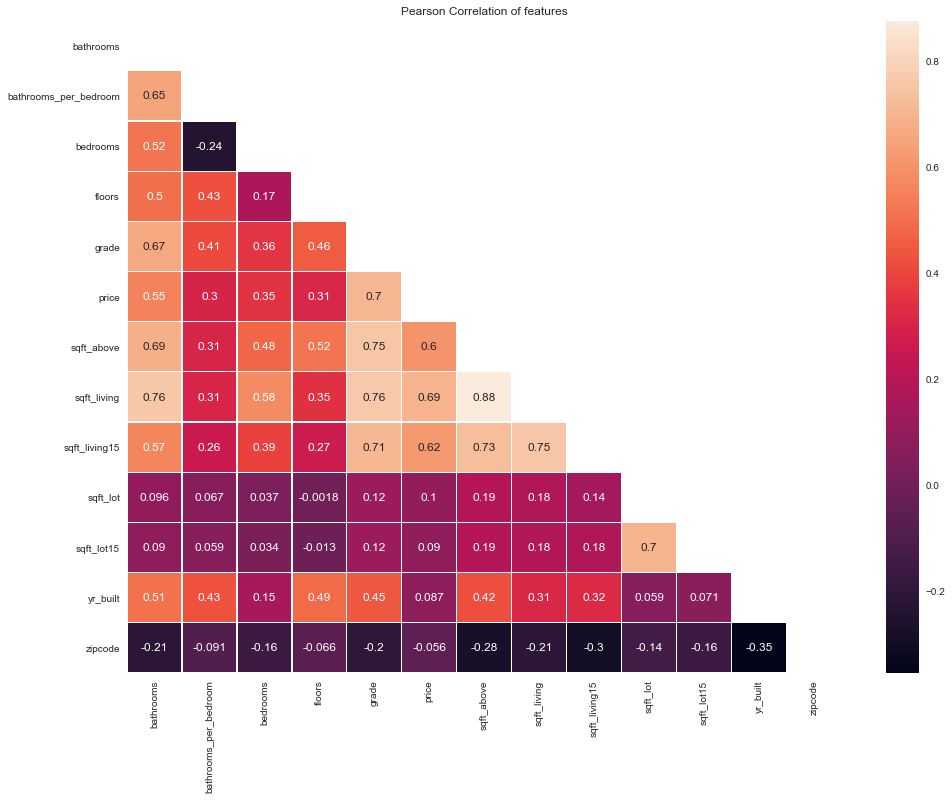

In [20]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in merged_king_data.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = merged_king_data.columns.difference(str_list) 
# Create Dataframe containing only numerical features
merged_king_data_num = merged_king_data[num_list]
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation of features')
# Draw the heatmap using seaborn
#sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="PuBuGn", linecolor='k', annot=True)
sns.heatmap(merged_king_data_num.astype(float).corr(),linewidths=0.25, annot=True, mask=np.triu(np.ones_like(num_list, dtype=bool)))


In [21]:
# assign price to the variable target_feature

target_feature = 'price'

In [22]:
# assign sqft_living to the variable most_correlated_feature to make a simple regression model.

most_correlated_feature = 'sqft_living'

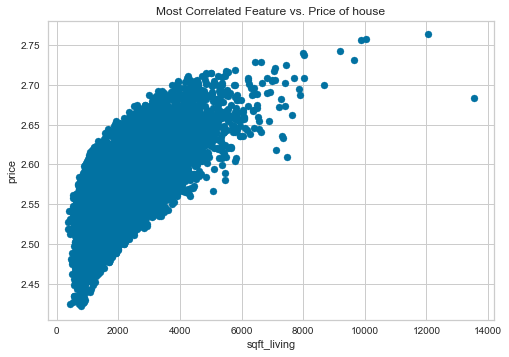

In [23]:
# plot a scatter plot to visulaize most correlated feature and target variable 
fig, ax = plt.subplots()

ax.scatter(x=merged_king_data[most_correlated_feature], y=merged_king_data[target_feature])
ax.set_xlabel(most_correlated_feature)
ax.set_ylabel(target_feature)
ax.set_title("Most Correlated Feature vs. Price of house");

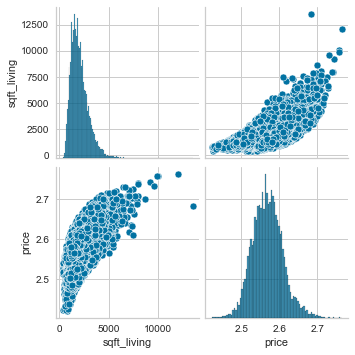

In [24]:
# see the distribution of the feature and target
slr_df = merged_king_data[['sqft_living', 'price']]
sns.pairplot(slr_df);

We identified sqft_living as the most correlated feature, we have a scatter plot that shows a fairly clear linear relationship between that feature and the target (log of price).

In [25]:
# make simple regression model

keep_cols = ['sqft_living']
X_train_sm = X_train_enc[keep_cols]

In [26]:
simple_mdl = LinearRegression()

In [27]:
simple_mdl.fit(X_train_sm, y_train)

LinearRegression()

In [28]:
summary_model(simple_mdl, X_train_sm, y_train)

R-squared: 0.4764138343563109 
Intercept: 2.506799519967085 
Coefficient: [2.99422937e-05]


### Multiple Regression Models

#### Model 1 - Includes all features

In [29]:
keep_cols = ['ohe__x0_EXCELLENT', 'ohe__x0_FAIR', 'ohe__x0_GOOD', 'ohe__x0_NONE',
       'ohe__x1_Fair', 'ohe__x1_Good', 'ohe__x1_Poor', 'ohe__x1_Very Good',
       'ohe__x2_Bellevue', 'ohe__x2_Black Diamond', 'ohe__x2_Bothell',
       'ohe__x2_Carnation', 'ohe__x2_Duvall', 'ohe__x2_Fall City',
       'ohe__x2_Federal Way', 'ohe__x2_Issaquah', 'ohe__x2_Kenmore',
       'ohe__x2_Kent', 'ohe__x2_Kirkland', 'ohe__x2_Maple Valley',
       'ohe__x2_Medina', 'ohe__x2_Mercer Island', 'ohe__x2_North Bend',
       'ohe__x2_Redmond', 'ohe__x2_Renton', 'ohe__x2_Sammamish',
       'ohe__x2_Seattle', 'ohe__x2_Snoqualmie', 'ohe__x2_Vashon', 'bedrooms',
       'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade', 'sqft_above',
       'yr_built', 'zipcode', 'sqft_living15', 'sqft_lot15',
       'bathrooms_per_bedroom']
X_train1 = X_train_enc[keep_cols]

In [30]:
model1 = LinearRegression()

model1.fit(X_train1, y_train)

LinearRegression()

In [31]:
summary_model(model1, X_train1, y_train)

R-squared: 0.7866744435011876 
Intercept: 35.39497822991161 
Coefficient: [ 1.80881154e-02  1.88380963e-03  2.67137542e-03 -7.29142289e-03
 -1.47491574e-02  3.83081026e-03 -1.71288962e-02  8.43817305e-03
  5.36805310e-02  2.45282246e-02  3.65405676e-02  3.16377036e-02
  3.33948749e-02  4.11792745e-02  2.65702257e-03  4.77472844e-02
  4.06610018e-02  1.66243772e-02  5.86999187e-02  2.66681244e-02
  9.27666941e-02  7.08527747e-02  4.23024424e-02  6.23013672e-02
  3.72202118e-02  6.22056727e-02  8.41782319e-02  5.23677775e-02
  5.57457671e-02  4.72232602e-04  3.73527042e-03  9.47985024e-06
  3.92421698e-08  3.69360148e-03  1.10224704e-02  1.39888682e-06
 -2.13711282e-04 -3.32398787e-04  8.06414527e-06 -3.16398591e-08
  5.44119321e-03]


In [32]:
cal_vif(X_train_enc)

,feature,VIF
0,ohe__x0_EXCELLENT,1.379046
1,ohe__x0_FAIR,1.391852
2,ohe__x0_GOOD,1.570303
3,ohe__x0_NONE,23.151037
4,ohe__x1_Fair,1.029312
5,ohe__x1_Good,1.726348
6,ohe__x1_Poor,1.013315
7,ohe__x1_Very Good,1.290781
8,ohe__x2_Bellevue,3.784054
9,ohe__x2_Black Diamond,1.186705


#### Model 2
Exclude 
- yr_built
- zipcode
- 
- 'ohe__x0_NONE' 
- 
- 
as predictors of the model as they have a high VIF indicating high multicollinearity. 

In [37]:
X_train_enc.columns

Index(['ohe__x0_EXCELLENT', 'ohe__x0_FAIR', 'ohe__x0_GOOD', 'ohe__x0_NONE',
       'ohe__x1_Fair', 'ohe__x1_Good', 'ohe__x1_Poor', 'ohe__x1_Very Good',
       'ohe__x2_Bellevue', 'ohe__x2_Black Diamond', 'ohe__x2_Bothell',
       'ohe__x2_Carnation', 'ohe__x2_Duvall', 'ohe__x2_Fall City',
       'ohe__x2_Federal Way', 'ohe__x2_Issaquah', 'ohe__x2_Kenmore',
       'ohe__x2_Kent', 'ohe__x2_Kirkland', 'ohe__x2_Maple Valley',
       'ohe__x2_Medina', 'ohe__x2_Mercer Island', 'ohe__x2_North Bend',
       'ohe__x2_Redmond', 'ohe__x2_Renton', 'ohe__x2_Sammamish',
       'ohe__x2_Seattle', 'ohe__x2_Snoqualmie', 'ohe__x2_Vashon', 'bedrooms',
       'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade', 'sqft_above',
       'yr_built', 'zipcode', 'sqft_living15', 'sqft_lot15',
       'bathrooms_per_bedroom'],
      dtype='object')

In [33]:
keep_cols = ['ohe__x0_EXCELLENT', 'ohe__x0_FAIR', 'ohe__x0_GOOD', 'ohe__x0_NONE',
       'ohe__x1_Fair', 'ohe__x1_Good', 'ohe__x1_Poor', 'ohe__x1_Very Good',
       'ohe__x2_Bellevue', 'ohe__x2_Black Diamond', 'ohe__x2_Bothell',
       'ohe__x2_Carnation', 'ohe__x2_Duvall', 'ohe__x2_Fall City',
       'ohe__x2_Federal Way', 'ohe__x2_Issaquah', 'ohe__x2_Kenmore',
       'ohe__x2_Kent', 'ohe__x2_Kirkland', 'ohe__x2_Maple Valley',
       'ohe__x2_Medina', 'ohe__x2_Mercer Island', 'ohe__x2_North Bend',
       'ohe__x2_Redmond', 'ohe__x2_Renton', 'ohe__x2_Sammamish',
       'ohe__x2_Seattle', 'ohe__x2_Snoqualmie', 'ohe__x2_Vashon', 'bedrooms',
       'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade', 'sqft_above',
       'yr_built', 'zipcode', 'sqft_living15', 'sqft_lot15',
       'bathrooms_per_bedroom']

X_train2 = X_train_enc[keep_cols]
model2 = LinearRegression()

model2.fit(X_train2, y_train)

KeyError: "['ohe__x3_Kent', 'ohe__x3_Redmond', 'ohe__x3_Duvall', 'ohe__x3_Medina', 'ohe__x2_13', 'ohe__x3_Snoqualmie', 'ohe__x3_Kenmore', 'ohe__x3_Bothell', 'ohe__x3_Vashon', 'ohe__x2_8', 'ohe__x3_Issaquah', 'ohe__x2_9', 'ohe__x3_Maple Valley', 'ohe__x3_North Bend', 'ohe__x2_6', 'ohe__x3_Black Diamond', 'ohe__x3_Seattle', 'ohe__x3_Renton', 'ohe__x3_Mercer Island', 'ohe__x3_Sammamish', 'ohe__x2_10', 'ohe__x2_12', 'ohe__x2_5', 'ohe__x3_Federal Way', 'ohe__x3_Bellevue', 'ohe__x2_11', 'ohe__x3_Carnation', 'ohe__x3_Fall City', 'ohe__x3_Kirkland'] not in index"

In [ ]:
summary_model(model2, X_train2, y_train)

In [34]:
cal_vif(X_train2)

NameError: name 'X_train2' is not defined

Model 3

In [ ]:
keep_cols = ['ohe__x0_EXCELLENT', 'ohe__x0_FAIR', 'ohe__x0_GOOD',
       'ohe__x1_Fair', 'ohe__x1_Good', 'ohe__x1_Poor', 'ohe__x1_Very Good',
       'ohe__x2_5', 'ohe__x2_6', 'ohe__x2_8', 'ohe__x2_9',
       'ohe__x2_10', 'ohe__x2_11', 'ohe__x2_12', 'ohe__x2_13',
       'ohe__x3_Bellevue', 'ohe__x3_Black Diamond', 'ohe__x3_Bothell',
       'ohe__x3_Carnation', 'ohe__x3_Duvall', 'ohe__x3_Fall City',
       'ohe__x3_Federal Way', 'ohe__x3_Issaquah', 'ohe__x3_Kenmore',
       'ohe__x3_Kent', 'ohe__x3_Kirkland', 'ohe__x3_Maple Valley',
       'ohe__x3_Medina', 'ohe__x3_Mercer Island', 'ohe__x3_North Bend',
       'ohe__x3_Redmond', 'ohe__x3_Renton', 'ohe__x3_Sammamish',
       'ohe__x3_Seattle', 'ohe__x3_Snoqualmie', 'ohe__x3_Vashon', 'sqft_living', 'sqft_lot', 'bathrooms_per_bedroom']
X_train3 = X_train_enc[keep_cols]
X_test3= X_test_enc[keep_cols]
model3 = LinearRegression()

model3.fit(X_train3, y_train)

In [ ]:
# X_new = SelectKBest(f_re, k=20).fit_transform(X, y)
X_new = feature_selection.f_regression(X=X_train3, y=y_train)
X_new

In [ ]:
feature_selection.SelectKBest(X_new)

In [ ]:
print(model3)

In [ ]:
summary_model(model3, X_train3, y_train)

In [ ]:
X_train3

In [ ]:
cal_vif(X_train3)

Look at errors for Model 3

In [ ]:
np.exp(y_train.max())

In [ ]:
# Grab training set predictions
train_preds = model3.predict(X_train3)

# And test preds
test_preds = model3.predict(X_test3)

In [ ]:
print("Training Metrics:")
# R2
print(f"R2: {r2_score(y_train, train_preds):.3f}")
# MAE
print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
# MSE
print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
# RMSE - just MSE but set squared=False
print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
# RMSE - just MSE but set squared=False
print(f"Root Mean Squared Error in $: {mean_squared_error(np.exp(y_train), np.exp(train_preds), squared=False)}")

In [ ]:
print("Testing Metrics:")
# R2
print(f"R2: {r2_score(y_test, test_preds):.3f}")
# MAE
print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
# MSE
print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
# RMSE - just MSE but set squared=False
print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")
# RMSE - just MSE but set squared=False
print(f"Root Mean Squared Error in $: {mean_squared_error(np.exp(y_test), np.exp(test_preds), squared=False)}")

In [ ]:


visualizer = ResidualsPlot(model3)

visualizer.fit(X_train3, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test3, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

In [ ]:
# sns.residplot(x=X_train3, y=y_train);

Autocorrelation

In [ ]:
resids = train_preds - y_train

In [ ]:
sm.stats.stattools.durbin_watson(resids) # YAyyyy

Deal with Leverage/outliers

In [ ]:
# # Instantiate and fit the visualizer
# visualizer = CooksDistance()
# visualizer.fit(X_train3, y_train)
# visualizer.show();

Statsmodel model 3

In [ ]:
X_train3.shape

In [ ]:
y_sm = pd.DataFrame(y_train)

In [ ]:
y_sm.shape

In [ ]:
endog = y_train
exog = X_train3
lin_reg_model = sm.OLS(endog=endog, exog=sm.add_constant(exog)).fit()

In [ ]:
# model4 = lin_reg_model.fit()

In [ ]:
lin_reg_model.summary()

### Visualizations

In [39]:
# model_score_fig, ax = plt.subplots(figsize=(10,6))
# sns.set_style("dark")

# ax.bar(regression_score.index, regression_score['test R^2'], color=["red", "grey", "grey", "grey", "darkblue"])
# plt.title('Model Progression', size=20)
# plt.xlabel('Model Iteration', size=15)
# plt.ylabel('Test R^2', size=15)
# plt.savefig('images/model_prog.png', bbox_inches = 'tight');